# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [213]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [214]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d = d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## Task 1. Prior predictive checks

In [215]:
model_ppc = CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim = model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

# Creation of pandas dataframe from resulting draws
df = sim.draws_pd()
display(df)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,mu,sigma,y
0,0.0,0.0,197.082,11.55440,182.381
1,0.0,0.0,171.276,7.22116,173.053
2,0.0,0.0,181.987,14.53070,196.094
3,0.0,0.0,175.554,11.19790,175.307
4,0.0,0.0,183.120,9.31575,180.222
...,...,...,...,...,...
995,0.0,0.0,169.728,11.04230,178.393
996,0.0,0.0,165.939,7.61325,168.024
997,0.0,0.0,163.635,9.79754,164.333
998,0.0,0.0,170.092,10.49590,154.069


1. Plot histograms of mu, sigma and simulated height.

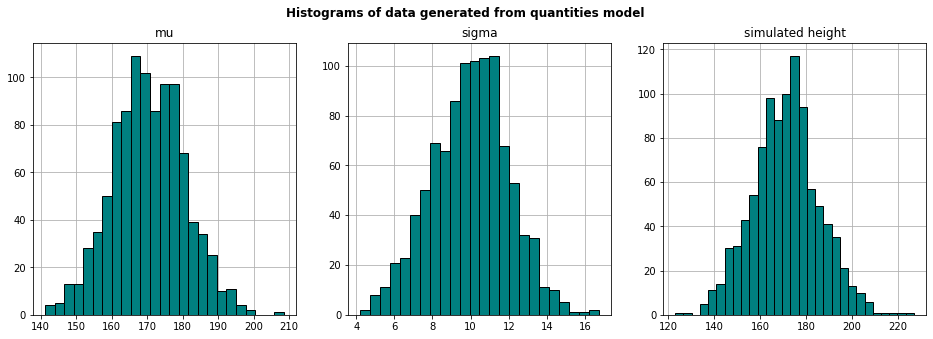

In [216]:
# Data of each 
mu = df['mu']
sigma = df['sigma']
sim_height = df['y']

# Histogram for each data
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
fig.suptitle('Histograms of data generated from quantities model', fontweight="bold")

for i, data in enumerate(zip([mu, sigma, sim_height], ['mu', 'sigma', 'simulated height'])):
    axs[i].hist(data[0], bins='auto', color='teal', edgecolor="black", zorder=3)
    axs[i].set_title(data[1])
    axs[i].grid(zorder=0)

plt.show()

2. Plot a joint distribution of mu and sigma.

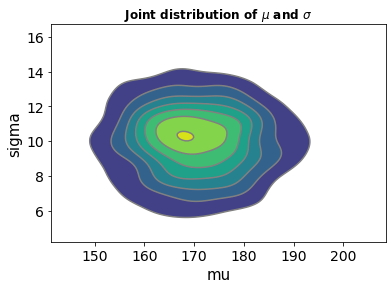

In [217]:
# Create an instance of the `InferenceData` object
data = az.from_dict({'mu': mu, 'sigma': sigma})

# Plot the joint distribution
az.plot_pair(data, var_names=['mu', 'sigma'], kind='kde')
plt.title(r'Joint distribution of $\mu$ and $\sigma$', fontweight="bold")
plt.show()

3. Check if samples are consistent with priors.

/tmp/ipykernel_339/3815805032.py:2: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = stats.kde.gaussian_kde(array)


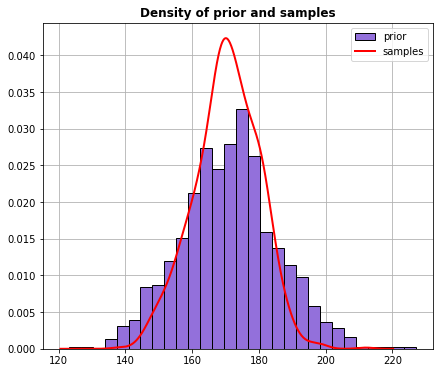

In [218]:
array = np.random.normal(loc=mu.mean(), scale=sigma.mean(), size=1000)
density = stats.kde.gaussian_kde(array)
x = np.linspace(mu.mean()-5*sigma.mean(), mu.mean()+5*sigma.mean(), 1000)
y = density(x)

plt.figure(figsize=(7,6))
plt.title('Density of prior and samples', fontweight="bold")
plt.hist(sim_height, bins='auto', density=True, color='mediumpurple', edgecolor="black", zorder=2, label="prior")
plt.plot(x, y, zorder=3, color="red", linewidth=2, label="samples")
plt.grid(zorder=0)
plt.legend()
plt.show()

4. Correct prior parameters to make them reasonably spreaded out. 

5. Check if observed data is possible to obtain using priors.

## Task 2. Model fit and evaluation

In [219]:
model_1_fit = CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [220]:
fit = model_1_fit.sample(data=dict(N=len(d), heights=d.height.values), seed=28052020)

df = fit.draws_pd()
display(df)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,height_sim
0,-889.924,0.999717,0.609087,2.0,3.0,0.0,891.237,154.508,7.62293,141.726
1,-890.204,0.959200,0.609087,1.0,3.0,0.0,890.497,154.661,7.46730,160.232
2,-891.365,0.659892,0.609087,1.0,3.0,0.0,892.784,153.891,7.64414,144.123
3,-891.236,1.000000,0.609087,2.0,3.0,0.0,891.380,155.254,7.80111,149.518
4,-890.201,1.000000,0.609087,2.0,3.0,0.0,891.130,154.400,7.87826,145.212
...,...,...,...,...,...,...,...,...,...,...
3995,-890.598,0.949246,0.600949,3.0,7.0,0.0,890.977,154.488,8.03223,158.178
3996,-890.521,0.967430,0.600949,2.0,5.0,0.0,891.265,154.592,7.37464,162.535
3997,-891.486,0.943554,0.600949,2.0,3.0,0.0,891.626,154.613,7.20315,154.324
3998,-890.255,0.993248,0.600949,2.0,3.0,0.0,891.651,154.309,7.54248,158.443


1. Plot a joint distribution of fitted mu and sigma.

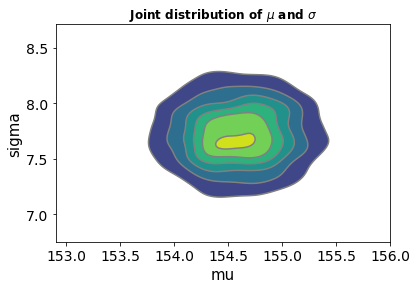

In [221]:
# Create an instance of the `InferenceData` object
data = az.from_dict({'mu': df['mu'], 'sigma': df['sigma']})

# Plot the joint distribution
az.plot_pair(data, var_names=['mu', 'sigma'], kind='kde')
plt.title(r'Joint distribution of $\mu$ and $\sigma$', fontweight="bold")
plt.show()

2. Plot histograms of data and simulated heights and evaluate the quality of model.

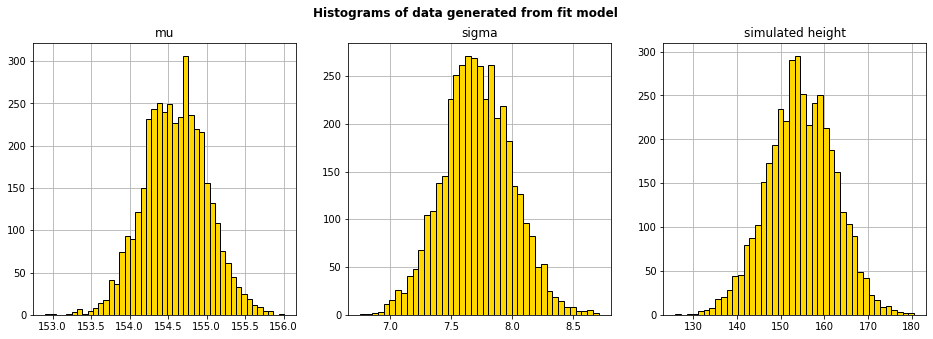

In [222]:
# Histogram for each data
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
fig.suptitle('Histograms of data generated from fit model', fontweight="bold")

for i, data in enumerate(zip([df['mu'], df['sigma'], df['height_sim']], ['mu', 'sigma', 'simulated height'])):
    axs[i].hist(data[0], bins='auto', color='gold', edgecolor="black", zorder=3)
    axs[i].set_title(data[1])
    axs[i].grid(zorder=0)

plt.show()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [223]:
mean_weight = d['weight'].mean()
d['c_weight'] = d['weight'] - mean_weight

data_sim = {'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

## Task 4. Prior predictive checks
 

In [224]:
model_ppc = CmdStanModel(stan_file='height_2a_ppc.stan')

R = 1000
sim = model_ppc.sample(data=data_sim, 
                       iter_sampling=R, 
                       iter_warmup=0, 
                       chains=1, 
                       refresh=R,
                       fixed_param=True,
                       seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

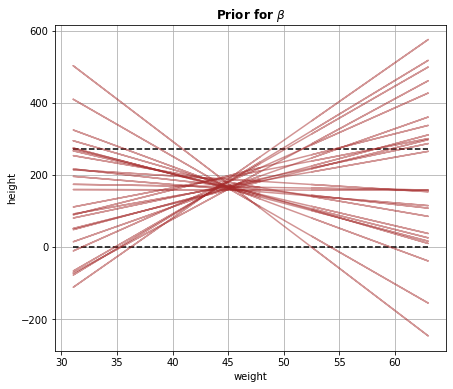

Predicted heights are not consistent with min and max.


In [225]:
# Creation of pandas dataframe from resulting draws
df = sim.draws_pd()
alpha_l = df['alpha'].to_list()[:25]
beta_l = df['beta'].to_list()[:25]
df.head()

fig, axes = plt.subplots(figsize=(7, 6))
axes.hlines([0, 272], xmin=d['weight'].min(), xmax=d['weight'].max(), linestyle="--", color="black")
for alpha, beta in zip(alpha_l, beta_l):
    axes.plot(d['weight'], alpha + beta*d['c_weight'], color='brown', alpha=0.5)
axes.set_title(r"Prior for $\beta$", fontweight="bold")
axes.set_xlabel("weight")
axes.set_ylabel("height")
axes.grid()
plt.show()

print("Predicted heights are not consistent with min and max.")

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [226]:
model_ppc = CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [227]:
sim = model_ppc.sample(data=data_sim, 
                       iter_sampling=R, 
                       iter_warmup=0, 
                       chains=1, 
                       refresh=R,
                       fixed_param=True,
                       seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

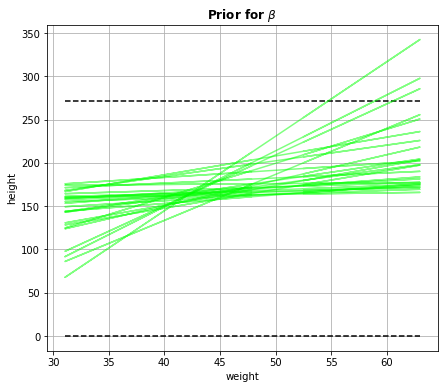

In [228]:
# Creation of pandas dataframe from resulting draws
df = sim.draws_pd()
alpha_l = df['alpha'].to_list()[:25]
beta_l = df['beta'].to_list()[:25]
df.head()

fig, axes = plt.subplots(figsize=(7, 6))
axes.hlines([0, 272], xmin=d['weight'].min(), xmax=d['weight'].max(), linestyle="--", color="black")
for alpha, beta in zip(alpha_l, beta_l):
    axes.plot(d['weight'], alpha + beta*d['c_weight'], color='lime', alpha=0.5)
axes.set_title(r"Prior for $\beta$", fontweight="bold")
axes.set_xlabel("weight")
axes.set_ylabel("height")
axes.grid()
plt.show()

2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

## Task 6. Fitting and evaluating model


In [229]:
model_2_fit = CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [230]:
N = 50
data_fit = {'N':N, 'weight':d.head(N)['weight'], 'heights':d.head(N)['height']}

fit = model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)

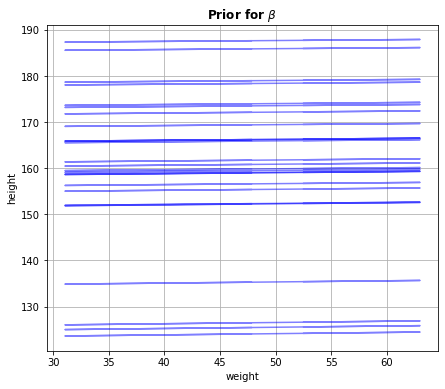

In [232]:
# Creation of pandas dataframe from resulting draws
df = fit.draws_pd()
alpha_l = df['alpha'].to_list()[:25]
beta_l = df['beta'].to_list()[:25]
df.head()

fig, axes = plt.subplots(figsize=(7, 6))
for alpha, beta in zip(alpha_l, beta_l):
    axes.plot(d['weight'], alpha + beta*d['c_weight'], color='blue', alpha=0.5)
axes.set_title(r"Prior for $\beta$", fontweight="bold")
axes.set_xlabel("weight")
axes.set_ylabel("height")
axes.grid()
plt.show()

2. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?
2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.
3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block. 